# Auto-Encoders

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
# keras
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import optimizers
import tensorflow as tf

# sklearn
from sklearn.metrics import mean_squared_error

# json
import json


# classes
class AutoEncoder(object):
    """ Keras-based AutoEncoder (AE) class used for event detection.
        Attributes:
        params: dictionary with parameters defining the AE structure,
    """
    def __init__(self, **kwargs):
        """ Class constructor, stores parameters and initialize AE Keras model. """

        # Default parameters values. If nI is not given, the code will crash later.
        params = {
            'nI': None,
            'nH': 3,
            'cf': 1,
            'activation' : 'tanh',
            'optimizer' : None,
            'verbose' : 0
            }

        for key,item in kwargs.items():
            params[key] = item

        self.params = params

    def create_model(self):
        """ Creates Keras AE model.
            The model has nI inputs, nH hidden layers in the encoder (and decoder)
            and cf compression factor. The compression factor is the ratio between
            the number of inputs and the innermost hidden layer which stands between
            the encoder and the decoder. The size of the hidden layers between the
            input (output) layer and the innermost layer decreases (increase) linearly
            according to the cg.
        """

        # retrieve params
        nI = self.params['nI'] # number of inputs
        nH = self.params['nH'] # number of hidden layers in encoder (decoder)
        cf = self.params['cf'] # compression factor
        activation = self.params['activation'] # autoencoder activation function
        optimizer = self.params['optimizer'] # Keras optimizer
        verbose = self.params['verbose'] # echo on screen

        # get number/size of hidden layers for encoder and decoder
        temp = np.linspace(nI,nI/cf,nH + 1).astype(int)
        nH_enc = temp[1:]
        nH_dec = temp[:-1][::-1]

        # input layer placeholder
        input_layer = Input(shape=(nI,))

        # build encoder
        for i, layer_size in enumerate(nH_enc):
            if i == 0:
                # first hidden layer
                encoder = Dense(layer_size, activation=activation)(input_layer)
            else:
                # other hidden layers
                encoder = Dense(layer_size, activation=activation)(encoder)

        # build decoder
        for i, layer_size in enumerate(nH_dec):
            if i == 0:
                # first hidden layer
                decoder = Dense(layer_size, activation=activation)(encoder)
            else:
                # other hidden layers
                decoder = Dense(layer_size, activation=activation)(decoder)

        # create autoencoder
        autoencoder = Model(input_layer, decoder)
        if optimizer == None:
            optimizer = tf.keras.optimizers.Adam(lr = 0.001)

        # print autoencoder specs
        if verbose > 0:
            print('Created autoencoder with structure:');
            print(', '.join('layer_{}: {}'.format(v, i) for v, i in enumerate(np.hstack([nI,nH_enc,nH_dec]))))

        # compile and return model
        autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
        return autoencoder

    def train(self, x, **train_params):
        """ Train autoencoder,
            x: inputs (inputs == targets, AE are self-supervised ANN).
        """
        if self.params['verbose']:
            if self.ann == None:
                print('Creating model.')
                self.create_model()
        self.ann.fit(x, x, **train_params)


    def predict(self, x, test_params={}):
        """ Yields reconstruction error for all inputs,
            x: inputs.
        """
        return self.ann.predict(x, **test_params)

class AEED(AutoEncoder):
    """ This class extends the AutoEncoder class to include event detection
        functionalities.
    """
    def initialize(self):
        """ Create the underlying Keras model. """
        self.ann = self.create_model()

    def predict(self, x, **keras_params):
        """ Predict with autoencoder. """
        preds = pd.DataFrame(index=x.index,columns=x.columns,
                                            data=super(AEED, self).predict(x.values,keras_params))
        errors = (x-preds)**2
        return preds, errors

    def detect(self, x, theta, window = 1, average=False, sys_theta = 0, **keras_params):
        """ Detection performed based on (smoothed) reconstruction errors.
            x = inputs,
            theta = threshold, attack flagged if reconstruction error > threshold,
            window = length of the smoothing window (default = 1 timestep, i.e. no smoothing),
            average = boolean (default = False), if True the detection is performed
                on the average reconstruction error across all outputs,
            keras_params = parameters for the Keras-based AE prediction.
        """
        #        preds = super(AEED, self).predict(x,keras_params)
        preds, temp = self.predict(x, **keras_params)
        temp = (x-preds)**2
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()
            detection = errors > theta
        else:
            errors = temp.rolling(window=window).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta))

        return detection, errors

    def save(self, filename):
        """ Save AEED model.
            AEED parameters saved in a .json, while Keras model is stored in .h5 .
        """
        # parameters
        with open(filename+'.json', 'w') as fp:
            json.dump(self.params, fp)
        # keras model
        self.ann.save(filename+'.h5')
        # echo
        print('Saved AEED parameters to {0}.\nKeras model saved to {1}'.format(filename+'.json', filename+'.h5'))


# functions
def load_AEED(params_filename, model_filename):
    """ Load stored AEED. """
    # load params and create AEED
    with open(params_filename) as fd:
        params = json.load(fd)
    aeed = AEED(**params)

    # load keras model
    aeed.ann = load_model(model_filename)
    return aeed

In [15]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras callbacks
# from keras.layers import Input, Dense
# from keras.models import Model, load_model
# from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time


# AutoEncoders for Event Detection (AEED)
# import AEED, load_AEED
# AEED = AEED()

In [16]:
# load training dataset
# data_path = "./data/"
df_train_orig = pd.read_csv("/content/drive/MyDrive/Sensor hack/Subdataset1.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_train_orig["ATT_FLAG"] = df_orig["ATT_FLAG"]
df_train_orig.columns = df_train_orig.columns.str.replace(' ', '')

# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)

# Train autoencoder

# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection (AEED)
autoencoder = AEED(**params)
autoencoder.initialize()



Created autoencoder with structure:
layer_0: 43, layer_1: 34, layer_2: 25, layer_3: 17, layer_4: 25, layer_5: 34, layer_6: 43


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(X1.values,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(X2.values, X2.values))

Epoch 1/500
184/184 - 1s - loss: 0.0777 - val_loss: 0.0311 - lr: 0.0010 - 1s/epoch - 7ms/step
Epoch 2/500
184/184 - 0s - loss: 0.0227 - val_loss: 0.0167 - lr: 0.0010 - 444ms/epoch - 2ms/step
Epoch 3/500
184/184 - 0s - loss: 0.0133 - val_loss: 0.0098 - lr: 0.0010 - 469ms/epoch - 3ms/step
Epoch 4/500
184/184 - 0s - loss: 0.0090 - val_loss: 0.0078 - lr: 0.0010 - 453ms/epoch - 2ms/step
Epoch 5/500
184/184 - 0s - loss: 0.0072 - val_loss: 0.0063 - lr: 0.0010 - 461ms/epoch - 3ms/step
Epoch 6/500
184/184 - 0s - loss: 0.0058 - val_loss: 0.0051 - lr: 0.0010 - 417ms/epoch - 2ms/step
Epoch 7/500
184/184 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 0.0010 - 401ms/epoch - 2ms/step
Epoch 8/500
184/184 - 0s - loss: 0.0037 - val_loss: 0.0034 - lr: 0.0010 - 462ms/epoch - 3ms/step
Epoch 9/500
184/184 - 0s - loss: 0.0032 - val_loss: 0.0029 - lr: 0.0010 - 405ms/epoch - 2ms/step
Epoch 10/500
184/184 - 0s - loss: 0.0027 - val_loss: 0.0025 - lr: 0.0010 - 403ms/epoch - 2ms/step
Epoch 11/500
184/184 - 0s - loss

In [18]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat)]


In [ ]:
df_test_01.columns

Index(['DATETIME', ' L_T1', ' L_T2', ' L_T3', ' L_T4', ' L_T5', ' L_T6',
       ' L_T7', ' F_PU1', ' S_PU1', ' F_PU2', ' S_PU2', ' F_PU3', ' S_PU3',
       ' F_PU4', ' S_PU4', ' F_PU5', ' S_PU5', ' F_PU6', ' S_PU6', ' F_PU7',
       ' S_PU7', ' F_PU8', ' S_PU8', ' F_PU9', ' S_PU9', ' F_PU10', ' S_PU10',
       ' F_PU11', ' S_PU11', ' F_V2', ' S_V2', ' P_J280', ' P_J269', ' P_J300',
       ' P_J256', ' P_J289', ' P_J415', ' P_J302', ' P_J306', ' P_J307',
       ' P_J317', ' P_J14', ' P_J422', 'ATT_FLAG'],
      dtype='object')

In [ ]:
df_train_orig.columns

Index(['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')

In [13]:
# data_path ="/content/aeed/data"
df_att_flags= pd.read_csv("/content/aeed/data/dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_orig = pd.read_csv("/content/aeed/data/dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [ ]:
df_att_flags["ATT_FLAG"]

0       0
1       0
2       0
3       0
4       0
       ..
4172    0
4173    0
4174    0
4175    0
4176    0
Name: ATT_FLAG, Length: 4177, dtype: int64

In [ ]:
df_test_01["ATT_FLAG"] = df_att_flags["ATT_FLAG"]

In [ ]:
# Load dataset with attacks
df_test_01 = pd.read_csv("/content/drive/MyDrive/Sensor hack/Subdataset2.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_01["ATT_FLAG"] = df_att_flags["ATT_FLAG"]
df_test_01.columns = df_test_01.columns.str.replace(' ', '')

# df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)
# sensor_cols = [col for col in df_test_01.columns if col not in ['DATETIME','ATT_FLAG']]
# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols,data = scaler.transform(df_test_01[sensor_cols]))
# X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
#                   data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
# Y4 = df_test_02['ATT_FLAG']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


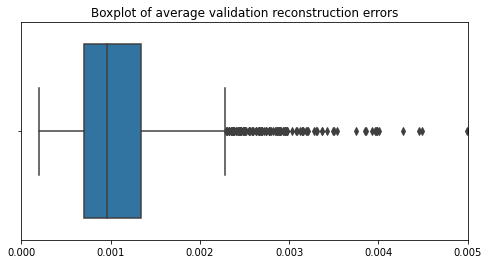

In [ ]:
# perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat3, _ = autoencoder.detect(X3, theta = theta , window = 3, average=True)
# Yhat4, _ = autoencoder.detect(X4, theta = theta, window = 3, average=True)

In [ ]:
Yhat3

0       False
1       False
2       False
3        True
4        True
        ...  
4172    False
4173    False
4174    False
4175     True
4176     True
Length: 4177, dtype: bool

In [ ]:
Y3

0       0
1       0
2       0
3       0
4       0
       ..
4172    0
4173    0
4174    0
4175    0
4176    0
Name: ATT_FLAG, Length: 4177, dtype: int64

In [ ]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
# results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall
test dataset 01  0.932248  0.692725   0.74359  0.648374
test dataset 02       NaN       NaN       NaN       NaN


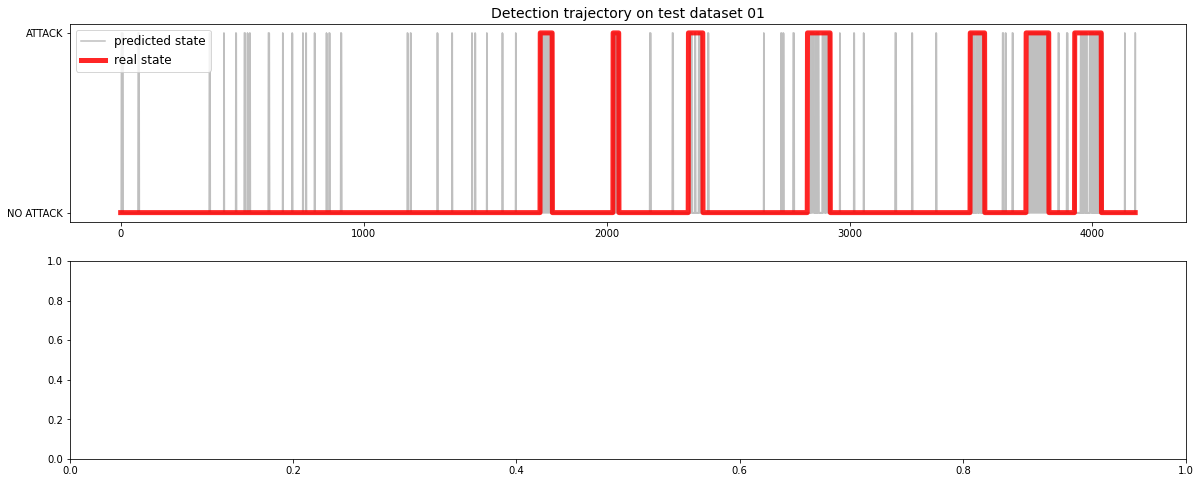

In [ ]:
# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,8))
axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Y3, color = 'r', alpha = 0.85, lw = 5, label = 'real state')
axes[0].set_title('Detection trajectory on test dataset 01', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)

# axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
# axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
# axes[1].plot(Y4, color = 'r', alpha = 0.75, lw = 5, label = 'real state')
# axes[1].set_title('Detection trajectory on test dataset 02', fontsize = 14)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

In [ ]:
# save autoencoder
autoencoder.save('/content/drive/MyDrive/Sensor hack/autoencoder')
# del autoencoder

Saved AEED parameters to /content/drive/MyDrive/Sensor hack/autoencoder.json.
Keras model saved to /content/drive/MyDrive/Sensor hack/autoencoder.h5


In [44]:
# load autoencoder
autoencoder = load_AEED('/content/drive/MyDrive/Sensor hack/autoencoder.json','/content/drive/MyDrive/Sensor hack/autoencoder.h5')

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

In [31]:
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat2, _ = autoencoder.detect(X2, theta = theta , window = 3, average=True)

In [33]:
Yhat2.value_counts()

False    2868
True       24
dtype: int64

# Result formation


In [5]:
import pandas as pd

In [51]:
df_test  = pd.read_csv("/content/drive/MyDrive/Sensor hack/Q1_IDS_test.csv")
df_test

INDEX(TIME_IN_HOURS)  L_T1  L_T2  L_T3  ...  P_J307  P_J317  P_J14  P_J422
0                        1  2.30  5.35  5.19  ...   20.36   67.64  32.87   31.97
1                        2  2.24  5.52  4.84  ...   21.51   69.23  39.58   29.91
2                        3  2.49  4.99  4.56  ...   21.93   70.46  39.91   29.38
3                        4  2.74  4.46  4.20  ...   22.12   69.87  40.16   28.91
4                        5  3.00  3.94  3.83  ...   21.64   69.29  39.57   28.37
...                    ...   ...   ...   ...  ...     ...     ...    ...     ...
1869                  1870  0.84  3.69  4.03  ...   18.83   66.88  30.80   29.90
1870                  1871  0.72  3.54  4.52  ...   19.30   69.03  30.75   29.85
1871                  1872  0.67  3.43  5.01  ...   25.62   71.57  30.68   29.78
1872                  1873  0.76  3.48  5.16  ...   25.84   72.43  31.21   30.31
1873                  1874  0.86  3.72  4.79  ...   26.16   73.59  31.49   30.59

[1874 rows x 44 columns]

In [49]:
validation_errors

L_T1      L_T2      L_T3  ...    P_J317         P_J14    P_J422
2484  0.000205  0.000096  0.000498  ...  0.000002  2.010403e-04  0.000011
2531  0.000293  0.006225  0.000005  ...  0.001447  3.534361e-05  0.000112
1699  0.000179  0.010330  0.005386  ...  0.001477  1.332844e-04  0.001169
2373  0.000336  0.000682  0.001268  ...  0.000010  6.973560e-04  0.000008
3767  0.002340  0.000673  0.001271  ...  0.000305  5.888354e-05  0.000007
...        ...       ...       ...  ...       ...           ...       ...
3207  0.001585  0.001246  0.000072  ...  0.000175  1.594560e-03  0.000014
4051  0.000073  0.002431  0.000271  ...  0.000097  1.858713e-04  0.000023
7213  0.000055  0.001421  0.000207  ...  0.000143  4.132437e-05  0.000242
4692  0.005466  0.000043  0.000082  ...  0.000013  7.128771e-04  0.000021
4092  0.001358  0.001772  0.002768  ...  0.007431  1.461622e-07  0.000760

[2892 rows x 43 columns]

In [52]:
_, validation_errors = autoencoder.predict(X_test)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sensor_cols = [col for col in df_test.columns if col not in ['INDEX(TIME_IN_HOURS)']]
X_test = pd.DataFrame(index = df_test.index, columns = sensor_cols, data = scaler.fit_transform(df_test[sensor_cols]))
autoencoder = load_AEED('/content/drive/MyDrive/Sensor hack/autoencoder.json','/content/drive/MyDrive/Sensor hack/autoencoder.h5')
theta = validation_errors.mean(axis = 1).quantile(0.995)
print(theta)
y_pred, _ =  autoencoder.detect(X_test, theta = theta , window = 3, average=True)

y_pred

0.13462535193722985


0       False
1       False
2       False
3       False
4       False
        ...  
1869    False
1870    False
1871    False
1872    False
1873    False
Length: 1874, dtype: bool

In [54]:
y_pred.value_counts()

False    1865
True        9
dtype: int64

In [55]:
df_test["LABEL"] = y_pred

In [56]:
df_test


INDEX(TIME_IN_HOURS)  L_T1  L_T2  L_T3  ...  P_J317  P_J14  P_J422  LABEL
0                        1  2.30  5.35  5.19  ...   67.64  32.87   31.97  False
1                        2  2.24  5.52  4.84  ...   69.23  39.58   29.91  False
2                        3  2.49  4.99  4.56  ...   70.46  39.91   29.38  False
3                        4  2.74  4.46  4.20  ...   69.87  40.16   28.91  False
4                        5  3.00  3.94  3.83  ...   69.29  39.57   28.37  False
...                    ...   ...   ...   ...  ...     ...    ...     ...    ...
1869                  1870  0.84  3.69  4.03  ...   66.88  30.80   29.90  False
1870                  1871  0.72  3.54  4.52  ...   69.03  30.75   29.85  False
1871                  1872  0.67  3.43  5.01  ...   71.57  30.68   29.78  False
1872                  1873  0.76  3.48  5.16  ...   72.43  31.21   30.31  False
1873                  1874  0.86  3.72  4.79  ...   73.59  31.49   30.59  False

[1874 rows x 45 columns]

In [60]:
result  = pd.DataFrame()
result["INDEX(TIME_IN_HOURS)"] = df_test["INDEX(TIME_IN_HOURS)"]
result["LABEL"] = df_test["LABEL"].apply(lambda x: "ATTACK" if x ==True else "NO ATTACK" )
result

INDEX(TIME_IN_HOURS)      LABEL
0                        1  NO ATTACK
1                        2  NO ATTACK
2                        3  NO ATTACK
3                        4  NO ATTACK
4                        5  NO ATTACK
...                    ...        ...
1869                  1870  NO ATTACK
1870                  1871  NO ATTACK
1871                  1872  NO ATTACK
1872                  1873  NO ATTACK
1873                  1874  NO ATTACK

[1874 rows x 2 columns]

In [62]:
result.to_csv("/content/drive/MyDrive/Sensor hack/result.csv",index=False)